# A/B Testing


## Table of Contents
## PART I. Proportions: Conversion Rate using z-test
## PART II. Means: Average User Posts using t-test

## PART I. Proportions: Conversion Rate using z-test
## 1. environment setup

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

## 2. calculate required sample size from user input

In [2]:
state = 22
alpha = 0.05
power = 0.8

baseline = float(input()) # e.g. 0.13 for 13% converted as base data
target = float(input())   # e.g. 0.15 for 15% target conversion rate

0.13
0.15


In [3]:
effect_size = sms.proportion_effectsize(baseline, target)
required_n = ceil(sms.NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1))

print(f"In this test, we need at least {required_n} samples from each group")

In this test, we need at least 4720 samples from each group


## 3. import and clean user data

In [43]:
df = pd.read_csv('./ab_data.csv')

In [5]:
# sanity check: control group should not land on "new page", and the treatment group should not land on the "old page"
pd.crosstab(df['landing_page'], df['group'])

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

# drop repeated user visits
df = df[~df['user_id'].isin(session_counts[session_counts > 1].index)]


## 4. sampling

In [6]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=state)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=state)


control_converted = control_sample[control_sample['converted'] == 1]['converted'].sum()
treatment_converted = treatment_sample[treatment_sample['converted'] == 1]['converted'].sum()

control_proportion = control_converted / required_n
treatment_proportion = treatment_converted / required_n

print(f'Converted: control: {control_converted:.4f}, treatment: {treatment_converted:.4f}')
print(f'Proportions: control: {control_proportion:.4f}, treatment: {treatment_proportion:.4f}')

Converted: control: 582.0000, treatment: 593.0000
Proportions: control: 0.1233, treatment: 0.1256


## 5. z-test

## 5.1 statistical significance

In [7]:
# CALCULATION BY HAND
# compute difference
d = control_proportion - treatment_proportion

# compute pooled proportion
pooled_proportion = (control_converted + treatment_converted) / (required_n + required_n)

# compute standard error
pooled_se = math.sqrt (pooled_proportion * (1 - pooled_proportion) * (1/required_n + 1/required_n))


## RESULTS ##

# compute z score
z = d / pooled_se 

# compute p-value
p = stats.norm.sf(abs(z))*2
print(f'z score: {z:.4f}, p value: {p:.4f}')


z score: -0.3430, p value: 0.7316


In [8]:
def is_significant(pvalue, alpha=0.05):
    if ((pvalue > alpha) | (pvalue < -alpha)):
        print(f"p-value of {pvalue:.4f} is not significant")
    else:
        print(f"p-value of {pvalue:.4f} is significant")

In [9]:
is_significant(p)

p-value of 0.7316 is not significant


## 5.2 practical significance: confidence interval

In [10]:
# normal approximation interval
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

z = 1.959964 # 95% CI look up
control_lower_bound = control_proportion - (z*(math.sqrt((control_proportion*(1-control_proportion))/required_n)))
control_uppeer_bound = control_proportion + (z*(math.sqrt((control_proportion*(1-control_proportion))/required_n)))

treatment_lower_bound = treatment_proportion - (z*(math.sqrt((treatment_proportion*(1-treatment_proportion))/required_n)))
treatment_uppeer_bound = treatment_proportion + (z*(math.sqrt((treatment_proportion*(1-treatment_proportion))/required_n)))

print(f'95% confidence level for control: lower {control_lower_bound:.4f} upper {control_uppeer_bound:.4f}')
print(f'95% confidence level for treatment: lower {treatment_lower_bound:.4f} upper {treatment_uppeer_bound:.4f}')



95% confidence level for control: lower 0.1139 upper 0.1327
95% confidence level for treatment: lower 0.1162 upper 0.1351


In [11]:
def is_confident(target, lower, upper):
    if ((target < lower) | (target > upper)):
        print(f'the target {target} not bounded by CI, we cannot be certain regarding the repeatability of future trials')
    else:
        print(f'the target {target} is bounded by CI, we can be certain regarding the repeatability of future trials')
        

In [12]:
## RESULT ##
is_confident(target, treatment_lower_bound, treatment_uppeer_bound)

the target 0.15 not bounded by CI, we cannot be certain regarding the repeatability of future trials


## 6. ALTERNATIVE: calculate statistics using library

In [13]:
z_stat, pval = proportions_ztest([control_converted, treatment_converted], [required_n, required_n])

(lc, lt), (uc, ut) = proportion_confint([control_converted, treatment_converted], nobs=[required_n, required_n], alpha=0.05)

print(f'Verification')
print(f'z: {z_stat:.4f}, p-value: {pval:.4f}')
print(f'95% CI for control group: {lc:.4f} to {uc:.4f}')
print(f'95% CI for treatment group: {lt:.4f} to {ut:.4f}')

# ALL CHECK

Verification
z: -0.3430, p-value: 0.7316
95% CI for control group: 0.1139 to 0.1327
95% CI for treatment group: 0.1162 to 0.1351


## PART II. Means: Average User Posts using t-test

## 2. Simulate Ad-hoc Data

In [14]:
population = 10000
sim_users = np.arange(population)
dfp = pd.DataFrame(data=sim_users, columns=['user id'])

In [15]:
day = np.random.normal(0.4, 5, sim_users.size)   # i.e. day users make 0.4 posts on average
night = np.random.normal(1.3, 3, sim_users.size) # i.e. night users make 1.3 posts on average

dfp['day'] = pd.Series(day, index=dfp.index)
dfp['night'] = pd.Series(night, index=dfp.index)


In [16]:
# 2.2 get sample

n_samples = 1000
dfs = dfp.sample(n_samples, random_state=state)

,user id,day,night
count,1000.000000,1000.000000,1000.000000
mean,4856.461000,0.212454,1.103697
std,2909.217403,4.823059,3.078787
min,0.000000,-13.883006,-8.863237
25%,2386.750000,-2.936184,-0.919597
50%,4772.000000,0.111659,1.142265
75%,7341.750000,3.518367,3.116245
max,9962.000000,17.256068,10.283566


In [18]:
# 2.3 random assignment 
is_control = np.random.choice([0, 1], size=n_samples)
dfs = dfs.assign(is_control=is_control)
dfs.describe()

,user id,day,night,is_control
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4856.461000,0.212454,1.103697,0.526000
std,2909.217403,4.823059,3.078787,0.499573
min,0.000000,-13.883006,-8.863237,0.000000
25%,2386.750000,-2.936184,-0.919597,0.000000
50%,4772.000000,0.111659,1.142265,1.000000
75%,7341.750000,3.518367,3.116245,1.000000
max,9962.000000,17.256068,10.283566,1.000000


<AxesSubplot:xlabel='day', ylabel='Density'>

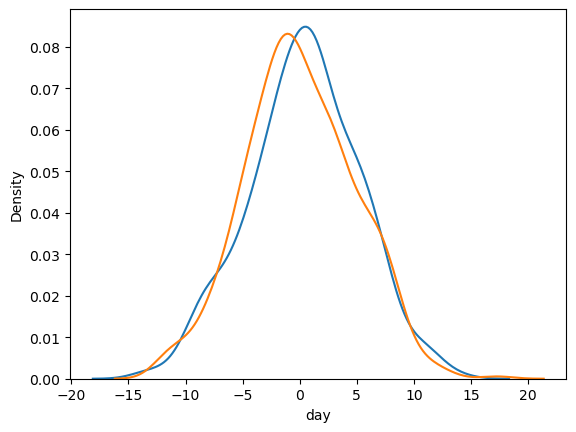

In [23]:
# 2.4 plot
# 1st experiment
sns.kdeplot(dfs[dfs.is_control == 0].day)
sns.kdeplot(dfs[dfs.is_control == 1].day)

<AxesSubplot:xlabel='night', ylabel='Density'>

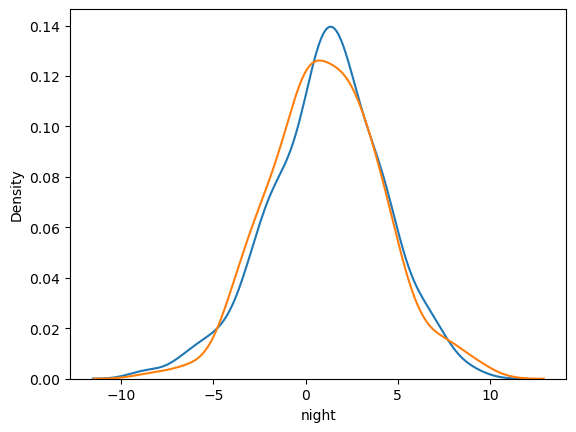

In [22]:
# 2nd experiment
sns.kdeplot(dfs[dfs.is_control == 0].night)
sns.kdeplot(dfs[dfs.is_control == 1].night)

<AxesSubplot:xlabel='day', ylabel='Density'>

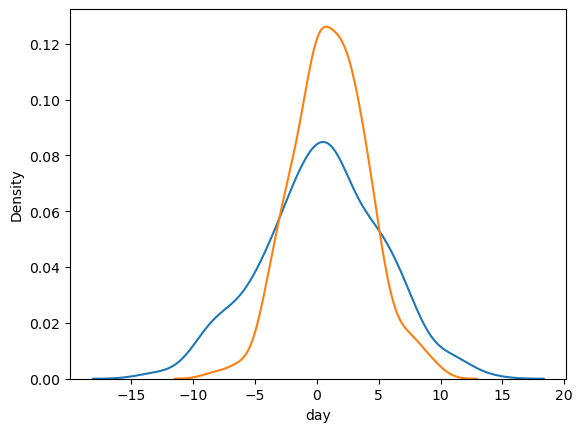

In [21]:
# 3rd experiment
sns.kdeplot(dfs[dfs.is_control == 0].day)
sns.kdeplot(dfs[dfs.is_control == 1].night)

In [38]:
# 2.5 t-test

def is_significant(group1, group2, alpha=0.05):
    t, p = stats.ttest_ind(group1, group2, equal_var=False)
    
    if (p<alpha):
        print(f"t-test is significant, with t statistic being {t:.4f}")
    else:
        print(f"t-test is NOT significant, with t statistic being {t:.4f}")
        

In [40]:
# 3 experiements as illustrated from the above graphs
is_significant(dfs[dfs.is_control == 0].day, dfs[dfs.is_control == 1].day)
is_significant(dfs[dfs.is_control == 0].night, dfs[dfs.is_control == 1].night)
is_significant(dfs[dfs.is_control == 0].day, dfs[dfs.is_control == 1].night)

t-test is NOT significant, with t statistic being 1.2413
t-test is NOT significant, with t statistic being 0.1766
t-test is significant, with t statistic being -2.6034
